<a href="https://colab.research.google.com/github/kailasa-Nischal/ML/blob/main/Lane_Detection_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow
import os
import sys
import random
import warnings
from tensorflow.keras.layers import Lambda
from tqdm import notebook, tnrange
from skimage.transform import resize
from random import randrange
from IPython.display import clear_output
import imageio

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
!unzip masks.zip -d /content
!unzip train.zip -d /content

Archive:  masks.zip
replace /content/masks/umm_road_000066.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/masks/umm_road_000053.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train.zip
replace /content/train/uu_000032.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def resize_image(img_resize_shape,image_path):
    img = plt.imread(image_path)
    img = cv2.resize(img,img_resize_shape)
    return img

In [ ]:
def gray_to_hsl(gray_image):
  mask_colored = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
  hsv_mask = cv2.cvtColor(mask_colored,cv2.COLOR_BGR2HSV)
  return hsv_mask

In [ ]:
def display(display_list, title, training=False):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')

  if (training):
    random_number = randrange(1000)
    try:
      plt.savefig("/content/training_images/"+str(random_number)+".png")
    except:
      os.mkdir('/content/training_images')
      plt.savefig("/content/training_images/"+str(random_number)+".png")

  plt.show()

In [ ]:
def show_predictions(training=False):
  image = X_train[100]
  mask = Y_train[100]
  blue_mask = gray_to_hsl(mask)

  masked_img = cv2.bitwise_or(image,blue_mask)

  sample_image = np.expand_dims(image, axis=0)
  predicted_mask = model.predict(sample_image)
  predicted_mask = (predicted_mask > 0.5).astype(np.float32)
  predicted_blue_mask = gray_to_hsl(predicted_mask[0])

  applied_predicted_mask = cv2.bitwise_or(image,predicted_blue_mask)

  display([image, mask, masked_img, predicted_mask[0], applied_predicted_mask], ["original image", "True mask", "Applied Mask", "Predicted Mask", "Applied Predicted_Mask"], training)

In [ ]:
def create_Training_Image_Gif():
  folder_path = "/content/training_images"
  training_images_for_gif = []
  image_files = next(os.walk(folder_path))[2]
  image_files = sorted(image_files)
  for n, id_ in notebook.tqdm(enumerate(image_files), total=len(image_files)):
    training_images_for_gif.append(imageio.imread(folder_path + '/' + image_files[n]))
    imageio.mimsave('/content/training_process.gif', training_images_for_gif)

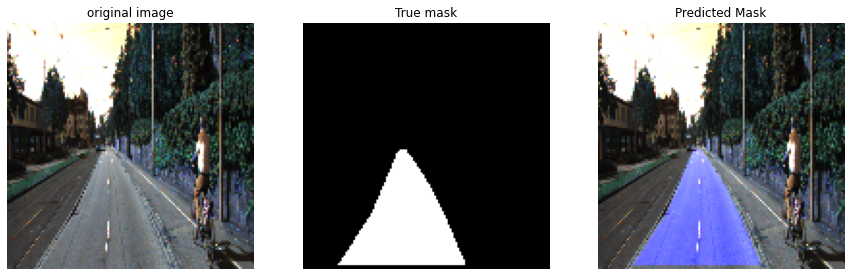

In [ ]:
for i in range(0,1):
  image = cv2.imread("/content/train/um_00000"+str(i)+".png")
  mask = cv2.imread("/content/masks/um_road_00000"+str(i)+".png")
  hsv_mask = cv2.cvtColor(mask,cv2.COLOR_BGR2HSV)
  masked_img = cv2.bitwise_or(image,hsv_mask)
  display([image, mask, masked_img], ["original image", "True mask", "Predicted Mask"])

In [ ]:
train = '/content/train'
masks= '/content/masks'

train_ids = next(os.walk(train))[2]
test_ids = next(os.walk(masks))[2]

train_ids = sorted(train_ids)
test_ids = sorted(test_ids)

In [ ]:
width = 128
height = 128
train_image_channels = 3
train_mask_channels = 1

In [ ]:
# Get and resize train images and masks
X_train = np.ndarray(shape=(len(train_ids), height, width, train_image_channels), dtype=np.float32)

i=0
path = train

for n, id_ in notebook.tqdm(enumerate(train_ids), total=len(train_ids)):
  img_path = path + '/'+train_ids[n]
  x = resize_image( (height, width), img_path)
  temp = np.zeros((height, width, train_image_channels))
  for j in range(train_image_channels):
    temp[:,:,j] = x[:,:,j]
  X_train[i] = temp
  i += 1

print('Done!')


Done!


In [ ]:
# Get and resize train images and masks
Y_train = np.ndarray(shape=(len(test_ids), height, width, train_mask_channels), dtype=np.float32)

i=0
path = masks

for n, id_ in notebook.tqdm(enumerate(test_ids), total=len(test_ids)):
  img_path = path + '/' + test_ids[n]
  x = resize_image( (height, width), img_path)
  temp = np.zeros((height, width, train_mask_channels))
  for j in range(train_mask_channels):
    temp[:,:,j] = x[:,:,j]
  Y_train[i] = temp
  i += 1

print('Done!')


Done!


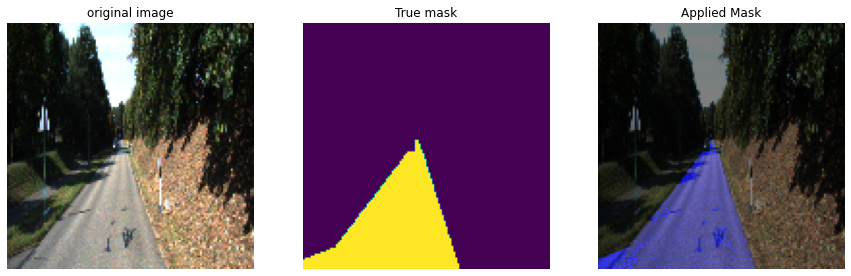

In [ ]:
for i in range(0,1):
  random_number = randrange(len(train_ids))
  image = X_train[random_number]
  mask = Y_train[random_number]
  blue_mask = gray_to_hsl(mask)
  masked_img = cv2.bitwise_or(image,blue_mask)
  display([image, mask, masked_img], ["original image", "True mask", "Applied Mask"])

In [ ]:
def build_model():
  InputLayer  = Input(shape=(128, 128, 3))
  ##ENCODING
  conv1 = Conv2D(8, (3,3), activation='relu', padding='same')(InputLayer)
  conv1 = Conv2D(8, (3,3), activation='relu', padding='same')(conv1)
  pool1 = MaxPool2D((2,2))(conv1)

  conv2 = Conv2D(16, (3,3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(16, (3,3), activation='relu', padding='same')(conv2)
  pool2 = MaxPool2D((2,2))(conv2)

  conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(conv3)
  pool3 = MaxPool2D((2,2))(conv3)

  conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(64, (3,3), activation='relu', padding='same')(conv4)
  pool4 = MaxPool2D((2,2))(conv4)

  ##BOTTLENECK
  conv5 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool4)
  conv5 = Conv2D(128, (3, 3), activation='relu', padding='same') (conv5)

  ##DECODING
  upcon6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv5)
  upcon6 = concatenate([upcon6, conv4])
  conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(upcon6)
  conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

  upcon7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv6)
  upcon7 = concatenate([upcon7, conv3])
  conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(upcon7)
  conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

  upcon8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(conv7)
  upcon8 = concatenate([upcon8, conv2])
  conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(upcon8)
  conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

  upcon9 = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(conv8)
  upcon9 = concatenate([upcon9, conv1], axis=3)
  conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(upcon9)
  conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

  new_model = Model(inputs=[InputLayer], outputs=[outputs])
  new_model.summary()
  return new_model

In [ ]:
model = build_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 8)  224         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 8)  584         conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_58[0][0]                  
____________________________________________________________________________________________

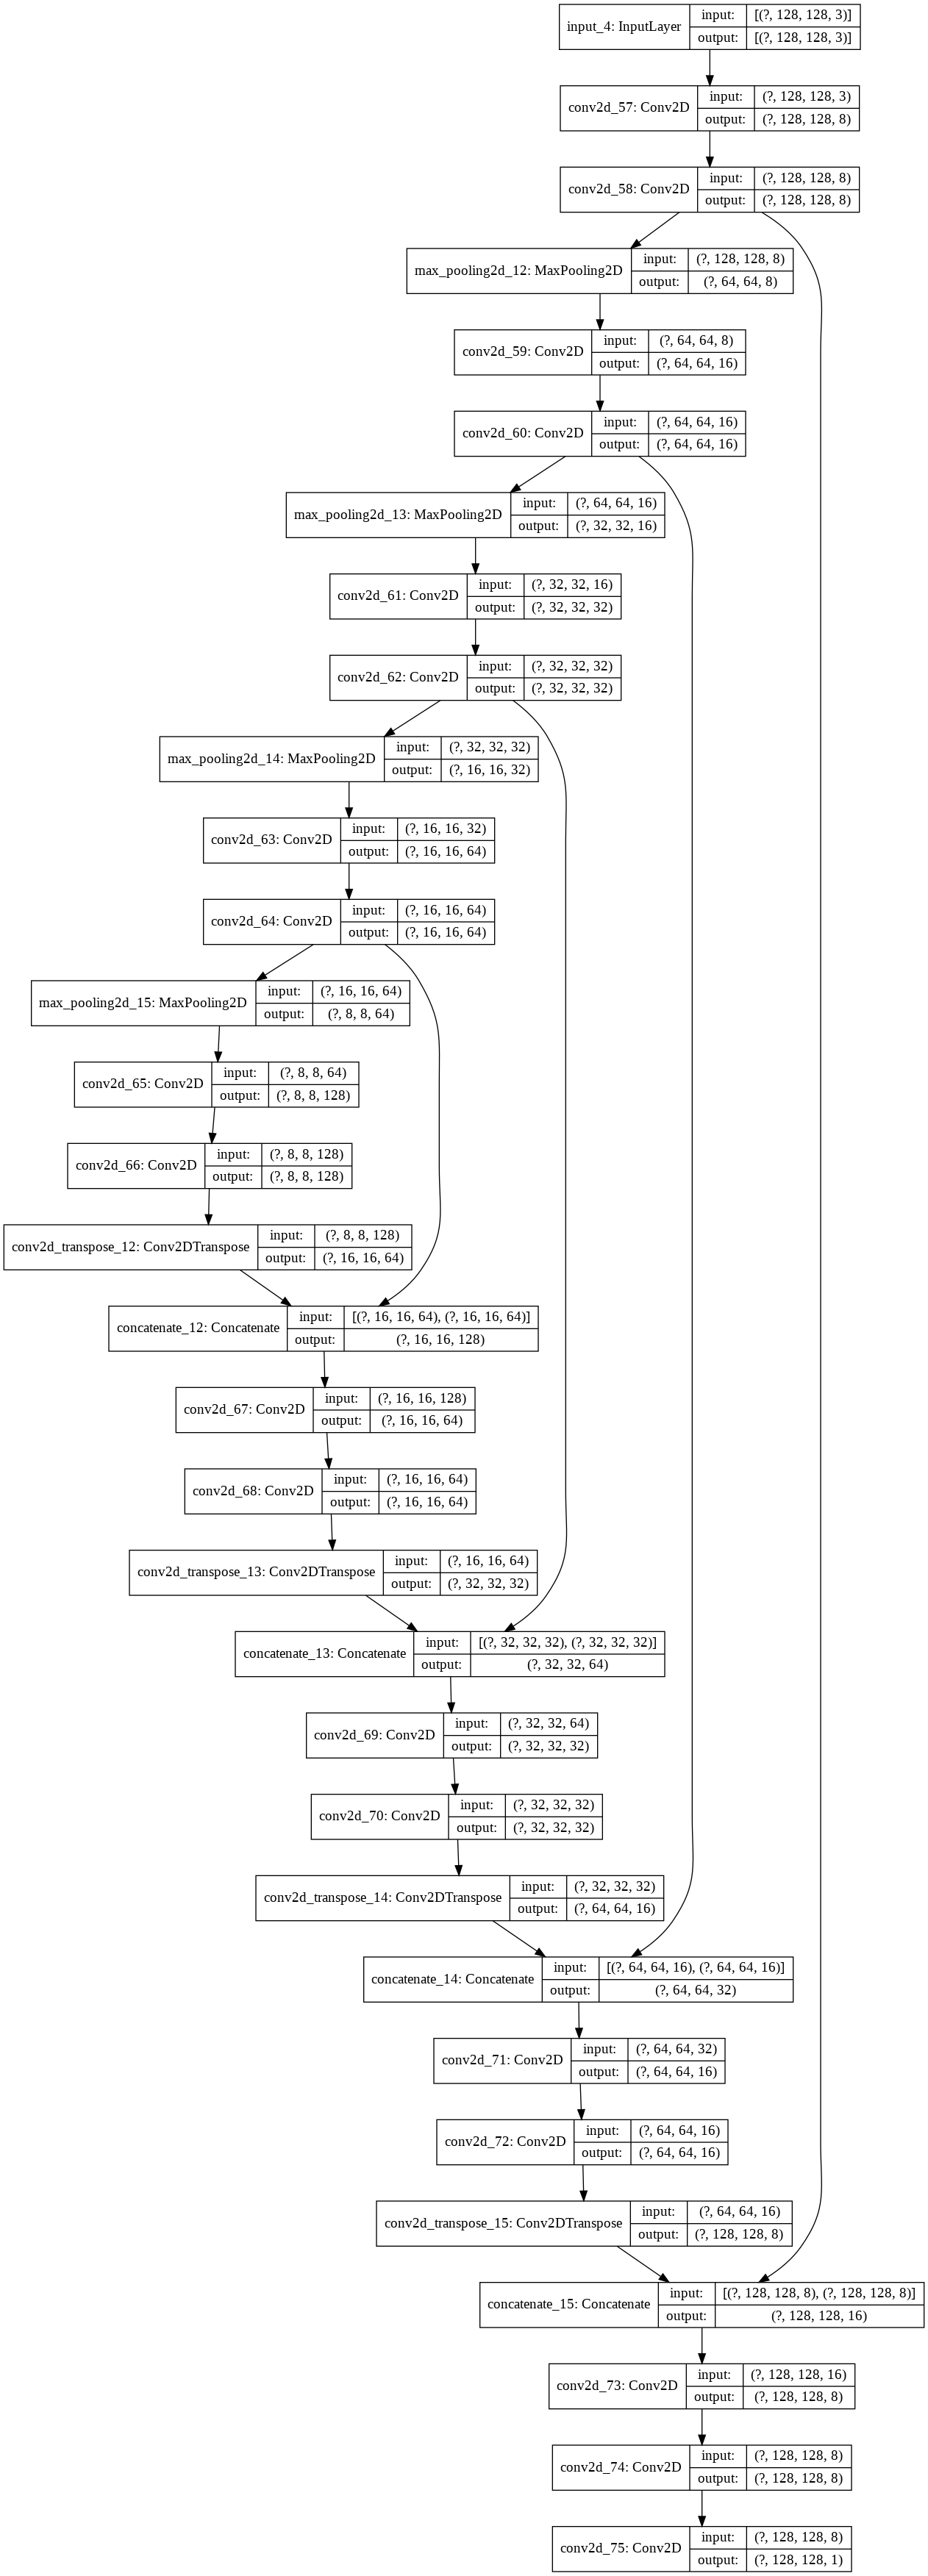

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(training=True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

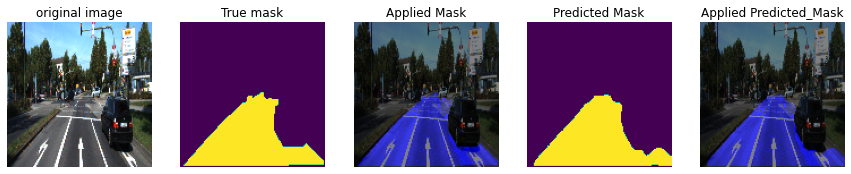


Sample Prediction after epoch 30

33/33 [==============================] - 1s 27ms/step - loss: 0.0373 - accuracy: 0.9845 - val_loss: 0.1205 - val_accuracy: 0.9595


In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[DisplayCallback()])

In [ ]:
create_Training_Image_Gif()